In [2]:
import torch

from model_architectures import DDPM, UNet

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# same settings you used during training
noise_net = UNet()  
T = 1_000     

ckpt_path = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/025_MNIST_basic_DDPM/checkpoints/ddpm-epoch=08-train_loss=0.0017.ckpt"

model = DDPM.load_from_checkpoint(
    ckpt_path,
    T=T,                     # must pass ctor args because you didn’t call
    noise_predictor=noise_net   # `self.save_hyperparameters()`
).to(device).eval()


In [3]:
nb_images = 16
with torch.no_grad():
    samples = model.sampling(
        n_samples=nb_images,
        image_channels=1,
        img_size=(32, 32)
    )


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.22it/s]


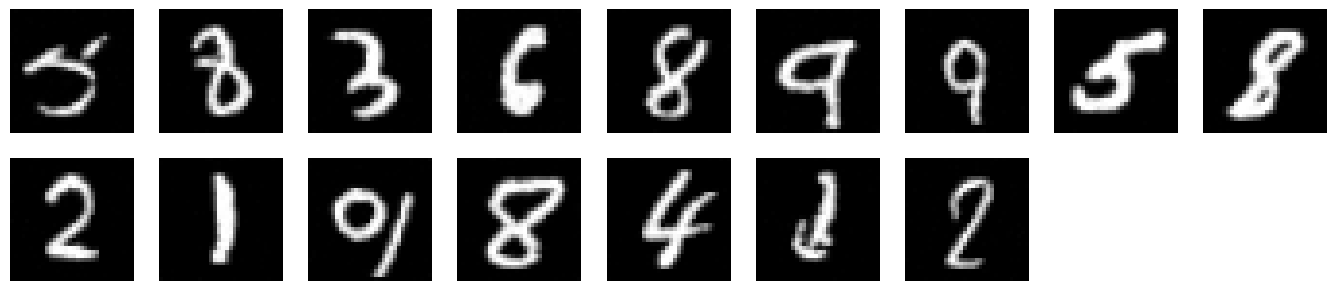

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 17))
for i in range(16):
    plt.subplot(9, 9, 1 + i)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(),
               cmap='gray')
# plt.savefig(f'inference/samples.png')